### 0. import libs

In [1]:
%run utils.ipynb

### 1. configs

In [2]:
image_dir = "./files/vehicle_models/"

### 2. load a random image

In [3]:
image_paths = get_all_images(image_dir, shuffle = False)

In [4]:
num = 1929 # 11 12 13 14 15 16 17 18 100  # 19   13  14   15  16   17 18 19 119  689
image_path = image_paths[num]  
image_name = image_path.name

In [5]:
image_path = r"files/4_split_400/广汽传祺--广汽传祺--传祺GS5--2012--2013--2014/传祺GS5__传祺GS5__2013款1.8T自动四驱尊贵版__9070813016674127f787cbfa4769270e1ff6fc18.jpg"
image = imread(image_path)
im_h, im_w = image.shape[:2]

- acquire the lp coords

In [6]:
(lp_x1, lp_y1, lp_x2, lp_y2), (lp_w, lp_h, lp_xc) = get_lp_coord(image_path)
roi_y2 = lp_y1

### 3. extract the ROI's y_upper 
- search region for the ROI's y_upper

In [7]:
sr_x1, sr_x2 = int(max(0, lp_x1 - 1.5*lp_w)), int(min(im_w, lp_x2 + 1.5*lp_w))
sr_y1, sr_y2 = int(max(0, lp_y1 - 1.45*lp_w)), int(min(im_h, lp_y1 - 0.8*lp_w))
sr_w,  sr_h = sr_x2 - sr_x1, sr_y2 - sr_y1

sr = cv2.cvtColor(image[sr_y1:sr_y2, sr_x1:sr_x2], cv2.COLOR_RGB2GRAY)

- plot lp and search region

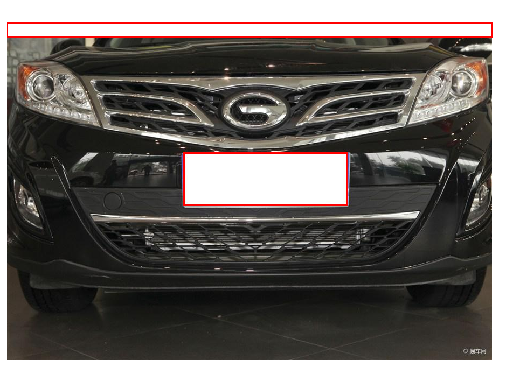

In [8]:
plt.figure(figsize=(16, 6.5))

# plt.title("search region of ROI's upper hood")
plt.imshow(image)
plt.gca().add_patch(plt.Rectangle(xy = (lp_x1, lp_y1), 
                                  width = lp_w, height = lp_h, edgecolor = 'red', fill = False, linewidth = 2))
plt.gca().add_patch(plt.Rectangle(xy = (sr_x1, sr_y1), 
                                  width = sr_w, height = sr_h, edgecolor = 'red', fill = False, linewidth = 2))

plt.plot()
plt.axis("off");

In [9]:
# blur the image 
sr_blur = cv2.GaussianBlur(sr, ksize=(5, 5), sigmaX=0, sigmaY=0)

# sobel y
sobel_sr_y = cv2.convertScaleAbs(cv2.Sobel(sr_blur, cv2.CV_16S, 0, 1, ksize = 3))

# horizontal projection and normalize
# 去除边缘图像左右两侧1/4的梯度信息，这部分信息可能包含车辆以外的梯度噪声，
# 对挡风玻璃下沿的投影效果产生影响
sobel_sr_y[:, :sobel_sr_y.shape[1]//4] = 0
sobel_sr_y[:, sobel_sr_y.shape[1]//4*3:] = 0

y_project = np.sum(sobel_sr_y, 1)
y_project = y_project / np.max(y_project)
y_project = mean_smooth(y_project, win_size = 10)

# the roi_y1
roi_y1 = np.argmax(y_project) + sr_y1

- plot soble y of sr and its y projection

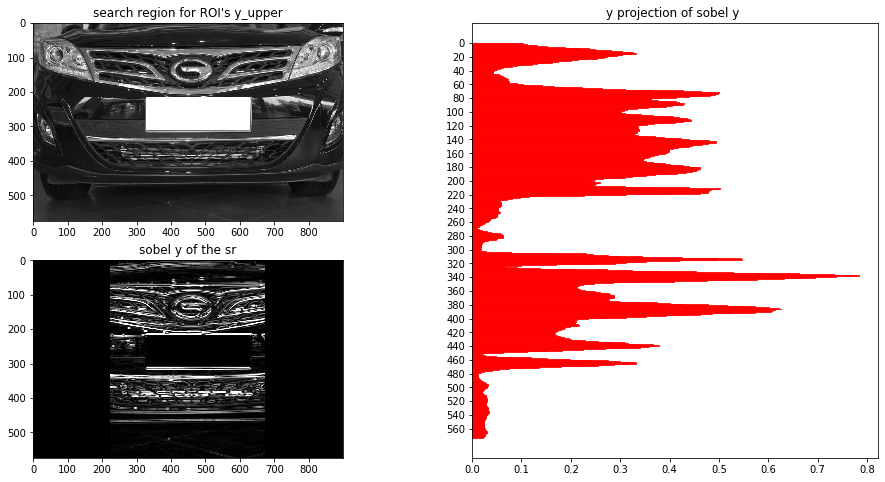

In [10]:
plt.figure(figsize=(16, 8))
plt.gray()

plt.subplot(221)
plt.title("search region for ROI's y_upper")
plt.imshow(sr)

plt.subplot(223)
plt.title("sobel y of the sr")
plt.imshow(sobel_sr_y)

plt.subplot(2,2,(2,4))
plt.title("y projection of sobel y ")
plt.barh(y = np.arange(y_project.shape[0], 0, -1), width = y_project, 
         color='red', height=1, alpha=0.8, edgecolor='red', );

plt.yticks(range(y_project.shape[0], 0, -20), range(0, y_project.shape[0], 20));

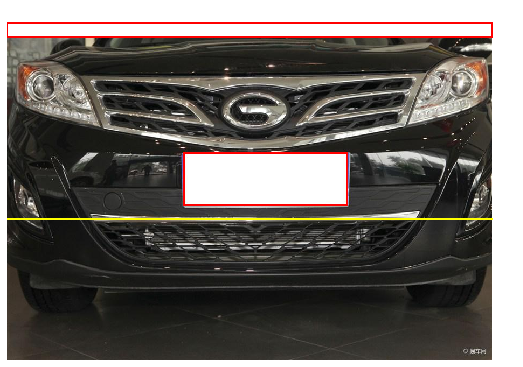

In [11]:
plt.figure(figsize=(16, 6.5))

# plt.title("search region of ROI's upper hood")
plt.imshow(image)
plt.gca().add_patch(plt.Rectangle(xy = (lp_x1, lp_y1), 
                                  width = lp_w, height = lp_h, edgecolor = 'red', fill = False, linewidth = 2))
plt.gca().add_patch(plt.Rectangle(xy = (sr_x1, sr_y1), 
                                  width = sr_w, height = sr_h, edgecolor = 'red', fill = False, linewidth = 2))

plt.plot((sr_x1, sr_x2), (roi_y1, roi_y1), color = "yellow", linewidth = 2)

plt.plot()
plt.axis("off");

### 4. extract the left and right bound of the ROI
- raw roi for the locating of the left and right side

In [12]:
raw_roi = cv2.cvtColor(image[roi_y1 : lp_y1, sr_x1 : sr_x2], cv2.COLOR_BGR2GRAY)
raw_roi_color = cv2.cvtColor(image[roi_y1 : lp_y1, sr_x1 : sr_x2], cv2.COLOR_BGR2RGB)

# 如果车牌左边界向左移动1.25个车牌宽度后距离图片边界大于20 则左侧的右边界=搜索区域左边界+0.55个车牌宽度
left_bound = sr_x1 + int(0.55*lp_w) if (lp_x1 - 1.25*lp_w) > 20 else 10
left_region = cv2.cvtColor(image[roi_y1:lp_y1, sr_x1 : left_bound], cv2.COLOR_BGR2GRAY)

# 如果车牌右边界向右移动1.25个车牌宽度后距离图片右边界大于20，则设定右侧边界的左边界=搜索区域右边界-0.55个车牌宽度
right_bound = int(sr_x2 - 0.55*lp_w) if (image.shape[1] - (lp_x2 + 1.25*lp_w)) > 20 else int(raw_roi.shape[1] - 10)
right_region = cv2.cvtColor(image[roi_y1:lp_y1, right_bound: sr_x2], cv2.COLOR_BGR2GRAY)

error: OpenCV(4.2.0) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [ ]:
plt.figure(figsize=(16, 6.5))
plt.subplot(1,2,1)
plt.imshow(left_region)
plt.title("left region")

plt.subplot(1,2,2)
plt.imshow(right_region)
plt.title("right region")
plt.plot();
# plt.axis("off");

In [ ]:
left_region[:left_region.shape[0]//5,:] = 0
left_region = cv2.GaussianBlur(left_region, ksize=(15, 15), sigmaX=0, sigmaY=0)

kernel=np.array([[-1,0,1],
                  [-1,0,1],
                  [-1,0,1],])

left_region = np.float32(left_region)
left_region = cv2.filter2D(left_region, -1, kernel)
left_region = cv2.convertScaleAbs(left_region) #
left_region = cv2.threshold(left_region,11,1,cv2.THRESH_OTSU)[1]
left_region = np.uint8(skeletonize(left_region)*255)
left_region = cv2.blur(left_region, (1, 5)) #left_region = cv2.GaussianBlur(left_region, ksize=(15, 15), sigmaX=0, sigmaY=0)


left_project = np.sum(left_region, 0)
left_project = left_project / np.max(left_project)
left_project = mean_smooth(left_project, win_size = 5)

x_left = np.argmax(left_project) #- 10
roi_x1 = x_left + sr_x1

In [ ]:
right_region[:right_region.shape[0]//5,:] = 0
right_region = cv2.GaussianBlur(right_region, ksize=(15, 15), sigmaX=0, sigmaY=0)

right_region = np.float32(right_region)
right_region = cv2.filter2D(right_region, -1, kernel)
right_region = cv2.convertScaleAbs(right_region) 
right_region = cv2.threshold(right_region,11,1,cv2.THRESH_OTSU)[1]
right_region = np.uint8(skeletonize(right_region)*255)
right_region = cv2.blur(right_region, (1, 5))#cv2.GaussianBlur(right_region, ksize=(15, 3), sigmaX=0, sigmaY=0)

right_project = np.sum(right_region, 0)
right_project = right_project /np.max(right_project)
right_project = mean_smooth(right_project, win_size = 5)

x_right = np.argmax(right_project) #+ 10
roi_x2 = x_right + right_bound

In [ ]:
dist = min(roi_x2 - lp_xc, lp_xc - roi_x1)

roi_x1, roi_x2 = lp_xc - dist, lp_xc + dist

In [ ]:
plt.figure(figsize=(16, 6.5))
plt.subplot(2,2,1)
plt.imshow(left_region)

plt.subplot(2,2,3)
plt.bar(x = np.arange(left_project.shape[0]), height = left_project, 
         color='red', width=1, alpha=0.8, edgecolor='red', );

plt.subplot(2,2,2)
plt.imshow(right_region)

plt.subplot(2,2,4)
plt.bar(x = np.arange(right_project.shape[0]), height = right_project, 
         color='red', width=1, alpha=0.8, edgecolor='red', );


In [ ]:
plt.figure(figsize=(16, 6.5))
plt.imshow(raw_roi_color)
# plt.title("ROI")
# left search region
plt.gca().add_patch(plt.Rectangle(xy = (0, 0), 
width = left_bound - sr_x1, height = raw_roi.shape[0], 
                                  edgecolor = 'red', fill = False, linewidth = 2, linestyle = "--"))
# right search region
plt.gca().add_patch(plt.Rectangle(xy = (right_bound - sr_x1, 0), 
                                  width = sr_x2 - right_bound, height = raw_roi.shape[0], 
                                  edgecolor = 'red', fill = False, linewidth = 2, linestyle = "--"))

plt.plot((roi_x1 - sr_x1, roi_x1 - sr_x1), (0, raw_roi.shape[0]), color = 'yellow', linewidth = 2, linestyle = "--")
plt.plot((roi_x2 - sr_x1, roi_x2 - sr_x1), (0, raw_roi.shape[0]), color = 'yellow', linewidth = 2, linestyle = "--")


plt.plot();
plt.axis("off");

In [ ]:
_, [roi_x11, roi_y11, roi_x12, roi_y12], _ = roi_extraction_1(image_path)
_, [roi_x21, roi_y21, roi_x22, roi_y22], _ = roi_extraction_2(image_path)

In [ ]:
plt.figure(figsize=(16, 6.5))
plt.imshow(image)
# plt.title("ROI in image")
# final roi
plt.gca().add_patch(plt.Rectangle(xy = (roi_x1, roi_y1), 
                                  width = roi_x2 - roi_x1, height = roi_y2 - roi_y1, 
                                  edgecolor = 'yellow', fill = False, linewidth = 3, linestyle = "--"))

plt.gca().add_patch(plt.Rectangle(xy = (roi_x11, roi_y11), 
                                  width = roi_x12 - roi_x11, height = roi_y12 - roi_y11, 
                                  edgecolor = 'blue', fill = False, linewidth = 3, linestyle = "--"))

plt.gca().add_patch(plt.Rectangle(xy = (roi_x21, roi_y21), 
                                  width = roi_x22 - roi_x21, height = roi_y22 - roi_y21, 
                                  edgecolor = 'red', fill = False, linewidth = 3, linestyle = "--"))

# lp
plt.gca().add_patch(plt.Rectangle(xy = (lp_x1, lp_y1), 
                                  width = lp_w, height = lp_h, edgecolor = 'red', fill = False, linewidth = 2))

plt.plot();
plt.axis("off");